## deblurring
repairing images motion blur
- channel attention mechanism [[paper]](https://arxiv.org/abs/1807.02758)
- residual in residual architecture [[paper]](https://arxiv.org/abs/1505.04597)
- subpixel convolution / pixelshuffle [[paper]](https://arxiv.org/abs/1609.05158)
- running on [tensorflow/google colab](https://colab.research.google.com/) AND on [tfdml](https://github.com/microsoft/DirectML/tree/master/TensorFlow)
- using the famous [Set14](https://www.google.com/search?q=set14) dataset ONLY (with heavy augmentation) - no validation needed

jupyter notebook by [Benjamin Wegener](https://scholar.google.de/citations?user=yEn9St8AAAAJ) from [github](https://www.github.com/BenjaminWegener/keras-examples)

- need miniconda3.10x64 numpy==1.26.4 matplotlib==3.9.2 scipy ==1.14.1

### options


In [1]:
run_on_google_colab = False #use PlaidML as Backend, change this to 'True' to run on colab/tf
epochs = 100 #Number of epochs to train
channels = 1 #channels of low resolution image
batch_size = 14 #what batch-size should we use (decrease if you encounter video memory errors)
steps_per_epoch = 100 #How much iterations per epoch to train
height_lr = 256 #height of low resolution image (must be dividable by 4)
width_lr = height_lr #width of low resolution image (must be dividable by 4)
gen_lr = 0.001 #learning rate of generator
logging_steps = 10 #how often to update the training log
rotation_max = 0.33 # max max degree of rotation
max_move = height_lr / 100 #how much pixels to shift the blurred image
blur_copies = 5 # how many copies of image to generate and merge back together

### imports

In [2]:
import os
if run_on_google_colab:
    %cd /content
    !git clone https://github.com/BenjaminWegener/keras-examples #download Dataset
    %cd keras-examples
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LambdaCallback
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from scipy.ndimage import rotate, shift
%matplotlib inline

### function for image visualization

In [13]:
from matplotlib.colors import NoNorm
def show(tensors):
    plt.rcParams['figure.figsize'] = [20, 10]
    fig = plt.figure()
    for i in range(len(tensors)):
        try:
            tensors[i] = np.squeeze(tensors[i], axis = 0)
        except:
            pass
        tensors[i] = (tensors[i] + 1.) * 127.5
        fig.add_subplot(1,len(tensors), i + 1)
        plt.imshow(tensors[i].astype(np.uint8), interpolation = 'nearest', norm = NoNorm())
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

### dataset function

In [14]:
# return batch of augmented train and target images with quantity n_samples
def get_batch(n_samples, height, width, channels):
    # define a ImageGenerator instance from keras with augmentations
    image_gen = ImageDataGenerator(rotation_range=360,
                           width_shift_range=0.5,
                           height_shift_range=0.5,
                           zoom_range=[0.2, 0.7],
                           horizontal_flip=True,
                           vertical_flip=True,
                           fill_mode='reflect',
                           data_format='channels_last',
                           brightness_range=[0.5, 1.5])
    #channels to color_mode
    if (channels == 1):
        mode = "grayscale"
        plt.gray()
    if (channels == 3):
        mode = "rgb"
    if (channels == 4):
        mode = "rgba"
    #seed for random augmentations
    random_seed = int(random.random() * 100000)
    #generate augmented images
    y_train = image_gen.flow_from_directory('.', target_size = (height, width), batch_size = n_samples, class_mode = None, color_mode = mode, seed = random_seed)
    y_train = y_train.__getitem__(0).copy() #fix for 'array doesn't own its data'
    x_train = y_train.copy()
    for i in range(n_samples):
        # source images are blurred (slightly rotated, moved and merged together)
        copy = x_train[i].copy()
        counter = 1
        for j in range(blur_copies):
            if (random.random() * 2 > 1) or (j == 1): #50% chance to make more than one copy
                rotation_angle = random.random() * rotation_max / 2 + rotation_max #minimum ratation is the half of maximum rotation
                copy = rotate(copy, rotation_angle, reshape=False, order=5, mode='reflect')
                move_amount_x = int(random.random() * max_move + 1) * 2 #allow for negative values
                move_amount_x = move_amount_x - move_amount_x / 2
                move_amount_y = int(random.random() * max_move + 1) * 2
                move_amount_y = move_amount_y - move_amount_y / 2
                copy = shift(copy, [move_amount_x, move_amount_y, 0], order=5, mode='reflect')
                counter = counter + 1
                x_train[i] = (1 - 1 / counter) * x_train[i] + 1 / counter * copy #blend back together
        x_train[i] = np.clip(x_train[i], 0, 255)
    #normalize images to [-1, 1]
    x_train = x_train/127.5 - 1.
    y_train = y_train/127.5 - 1.
    return x_train, y_train

### base functions

In [15]:
def fast_normalization(x): # use clipping instead of batchnormalization for network stabilization
    return Lambda(lambda x: K.clip(x, -1, 1), output_shape=lambda s: (s[0], s[1], s[2], s[3]))(x)

def residual_block(inputs): #combined pixel shuffle and squeeze
    x = inputs
    x = Conv2D(32, kernel_size = 9, activation = 'tanh', padding = 'same', strides = 2)(x)
    x = SeparableConv2D(128, kernel_size = 9, activation = 'tanh', padding = 'same')(x) # rapidly increase speed at slightly worse results
    x = fast_normalization(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2], 32, 2, 2)), output_shape = lambda s: (s[0], s[1], s[2], s[3] // 4, 2, 2))(x)
    x = Permute((3, 2, 4, 1, 5))(x)
    x = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], K.shape(x)[1], K.shape(x)[2] * K.shape(x)[3], K.shape(x)[4] * K.shape(x)[5])), output_shape = lambda s: (s[0], s[1], s[2] * s[3], s[4] * s[5]))(x)
    x = Permute((3, 2, 1))(x)
    #---
    x1 = x
    x = GlobalAveragePooling2D()(x)
    x = Dense(8, activation = 'relu')(x) #reduction like in RCAN
    x = Dense(32, activation = 'hard_sigmoid')(x)
    x = Reshape((1, 1, 32))(x)
    x = Multiply()([x1, x])
    #x = Add()([inputs, x])
    return x

### build generator model

In [16]:
x = inputs = Input(shape = (height_lr, width_lr, channels))
x = Conv2D(32, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = Conv2D(channels, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)
#x = Add()([inputs, x])

generator = Model(inputs = inputs, outputs = x)
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 256, 256, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 128, 128, 32  82976       ['conv2d_10[0][0]']              
                                )                                                           

### train

epoch 2 / 100 --> step 20 / 100 : loss 0.1098615974187851
1/1 [==============================] - 0s 48ms/step


<Figure size 2000x1000 with 0 Axes>

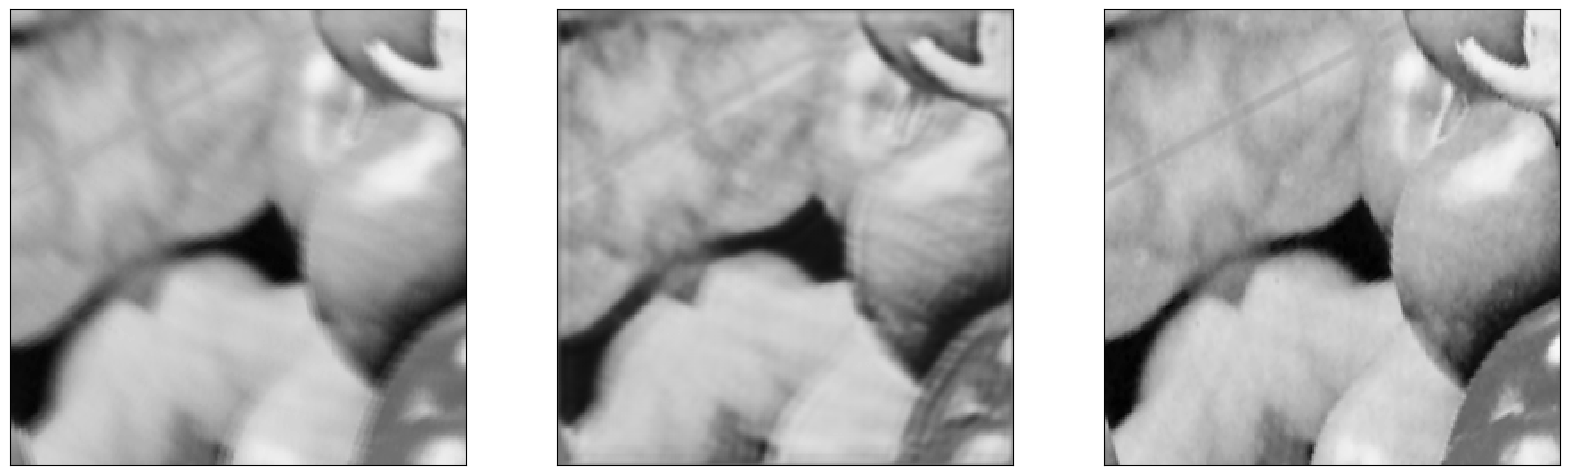

test_loss: 0.06785523146390915


In [ ]:
#load checkpoint & compile the generator network
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('deblurring_weights')
    print('success.')
except:
    print('failed')
    pass

generator.compile(optimizer = Adam(gen_lr), loss = 'mae')

# Train generator
def logging(epoch, logs):
    if epoch % logging_steps == 0:
        testX, testY = get_batch(1, height_lr, width_lr, channels)
        clear_output()
        print('epoch', real_epoch + 1, '/', epochs, '--> step', epoch, '/', steps_per_epoch, ': loss', logs['loss'])
        testZ = generator.predict(testX)
        show([testX, testZ, testY])
        print('test_loss:', generator.evaluate(testX, testY, verbose = 0))
logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: logging(epoch, logs)
)
for real_epoch in range(epochs):
    X, Y = get_batch(batch_size, height_lr, width_lr, channels)
    generator.fit(X, Y, batch_size, epochs = steps_per_epoch, verbose = 0, callbacks = [logging_callback], shuffle = True)
    try:
        print('trying to save weights...', end = ' ')
        generator.save_weights('deblurring_weights')
        print('success.')
    except:
        print('failed.')

### validate on complete picture

In [ ]:
from PIL import Image
testY = np.array(Image.open('./Set14/lenna.png'))
testX = testY.copy()
height = testX.shape[0]
width = testX.shape[1]
max_move = height / 100
# source image distortion wirth motionblur
copy = testX.copy()
counter = 1
for j in range(blur_copies):
    if (random.random() * 2 > 1) or (j == 1): #50% chance to make more than one copy
        rotation_angle = random.random() * rotation_max / 2 + rotation_max #minimum ratation is the half of maximum rotation
        copy = rotate(copy, rotation_angle, reshape=False, order=5, mode='reflect')
        move_amount_x = int(random.random() * max_move + 1) * 2 #allow for negative values
        move_amount_x = move_amount_x - move_amount_x / 2
        move_amount_y = int(random.random() * max_move + 1) * 2
        move_amount_y = move_amount_y - move_amount_y / 2
        copy = shift(copy, [move_amount_x, move_amount_y, 0], order=5, mode='reflect')
        counter = counter + 1
        testX = (1 - 1 / counter) * testX + 1 / counter * copy #blend back together
testX = np.clip(testX, 0, 255)
testX = testX /127.5 - 1
testY = testY /127.5 - 1
x = inputs = Input(shape = testX.shape)
x = Conv2D(32, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = residual_block(x)
x = Conv2D(3, kernel_size = 3, padding = 'same', activation = 'tanh')(x)
x = fast_normalization(x)
generator = Model(inputs = inputs, outputs = x)
print('trying to load last saved weights...', end = ' ')
try:
    generator.load_weights('deblurring_weights')
    print('success.')
except:
    print('failed')
    pass
predicted = generator.predict(np.expand_dims((testX), 0))
show([testX, predicted, testY])
predicted = np.squeeze(predicted)
predicted = Image.fromarray(((predicted + 1) * 127.5).astype(np.uint8))

print('trying to save image as \'debluring_result.png\'...', end = ' ')
try:
    predicted.save('debluring_result.png', "PNG")
    print('success.')
except:
    print('failed.')
    pass